# Example usage of widefield in `neuralib.wrapper.rastermap`

In [1]:
from __future__ import annotations
import attrs
import numpy as np

import rastermap.utils
from rastermap import Rastermap
from scipy.stats import zscore

from neuralib.plot import plot_figure, ax_merge
from neuralib.util.util_type import PathLike
from neuralib.wrapper.rastermap import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


- seealso [rastermap](https://github.com/MouseLand/rastermap) and [colab example](https://colab.research.google.com/github/MouseLand/rastermap/blob/main/notebooks/rastermap_widefield.ipynb)

In [2]:
%load_ext autoreload
%autoreload

### Example of Wfield pipeline
- prepare a container for image sequences information and computed singular_vector

In [3]:
@attrs.define
class RasterMapInput:

    height: int
    width: int

    # singular vector
    n_components: int
    sv: np.ndarray
    """(C, ) singular values"""
    Vsv: np.ndarray
    """(T, C) right singular vector"""
    U: np.ndarray
    """left singular vector (W * H, C)"""

    image_time: np.ndarray
    visual_stim_time: np.ndarray
    position: np.ndarray
    velocity: np.ndarray

    @classmethod
    def compute_singular_vector(cls, sequences: np.ndarray, n_components: int) -> tuple[np.ndarray, ...]:
        """compute the singular values, right singular vector and left singular vector"""
        from sklearn.decomposition import TruncatedSVD

        n_frames = sequences.shape[0]
        width = sequences.shape[1]
        height = sequences.shape[2]
        
        # to 2D voxel
        seq = sequences.reshape(self.n_frames, self.height * self.width).T
        seq = seq - np.mean(seq, axis=1, keepdims=True)

        svd = TruncatedSVD(n_components=n_components)
        Vsv = svd.fit_transform(seq.T)
        U = seq @ (Vsv / (Vsv ** 2).sum(axis=0) ** 0.5)
        U /= (U ** 2).sum(axis=0) ** 0.5

        return svd.singular_values_, Vsv, U


    @property
    def xpos(self) -> np.ndarray:
        x = np.arange(self.width)
        y = np.arange(self.height)
        return np.meshgrid(x, y)[0]

    @property
    def ypos(self) -> np.ndarray:
        x = np.arange(self.width)
        y = np.arange(self.height)
        return np.meshgrid(x, y)[1]

    @property
    def visual_stim_start(self) -> float:
        return self.visual_stim_time[0, 0]

    def visual_stim_trange(self, trange: tuple[float, float]) -> np.ndarray:
        """select visual stim time range segments

        :return (nStim, 2)
        """
        vt = self.visual_stim_time  # (N,2) -> (N*2)
        start_idx, end_idx = np.searchsorted(vt.ravel(), list(trange))

        # map to (N, 2)
        start_stim_idx = int(start_idx // 2)
        end_stim_idx = int(end_idx // 2)

        if start_idx % 2 != 0:
            vt[start_stim_idx, 0] = trange[0]

        if end_idx % 2 != 0:
            vt[end_stim_idx, 1] = trange[1]

        return vt[start_stim_idx: end_stim_idx]

In [4]:
# Prepare config dict
DEFAULT_WFIELD_RASTER_OPT: RasterOptions = {
    'n_clusters': 50,
    'locality': 0.5,
    'time_lag_window': 10,
    'grid_upsample': 10
}

In [5]:
def run_rastermap_wfield(dat: RasterMapInput,
                         ops: RasterOptions | None = None,
                         neuron_bins: int = 500,
                         **kwargs) -> RasterMapResult:
    if ops is None:
        ops = DEFAULT_WFIELD_RASTER_OPT

    ops['n_PCs'] = dat.n_components

    model = Rastermap(
        n_clusters=ops['n_clusters'],
        n_PCs=ops['n_PCs'],
        locality=ops['locality'],
        time_lag_window=ops['time_lag_window'],
        grid_upsample=ops['grid_upsample'],
        **kwargs
    ).fit(
        Usv=dat.U * dat.sv,  # left singular vectors weighted by the singular values
        Vsv=dat.Vsv  # right singular vectors weighted by the singular values
    )

    embedding = model.embedding
    isort = model.isort
    Vsv_sub = model.Vsv  # these are the PCs across time with the mean across voxels subtracted

    U_sn = rastermap.utils.bin1d(dat.U[isort], bin_size=neuron_bins, axis=0)  # bin over voxel axis
    sn = U_sn @ Vsv_sub.T
    sn = zscore(sn, axis=1)

    ret = RasterMapResult(
        filename='',  # replace to user specific
        save_path='',  # replace to user specific
        isort=isort,
        embedding=embedding,
        ops=ops,
        user_clusters=[],
        super_neurons=sn
    )

    return ret

# =============================== #
# Plot cluster and Voxel colormap #
# =============================== #

def plot_rastermap_sort(dat: RasterMapInput,
                        raster: RasterMapResult,
                        trange: tuple[int, int]):
    tmask = np.logical_and(trange[0] <= dat.image_time, dat.image_time <= trange[1])
    time = dat.image_time[tmask]

    with plot_figure(None, 11, 20, gridspec_kw={'wspace': 1, 'hspace': 0.3}) as _ax:
        # position
        ax1: Axes = ax_merge(_ax)[0, :-1]
        ax1.plot(time, dat.position[tmask], color='k')
        ax1.axis("off")
        ax1.set_title("position", color='k')

        # running speed
        ax2: Axes = ax_merge(_ax)[1, :-1]
        ax2.plot(time, dat.velocity[tmask], color='k')
        ax2.axis("off")
        ax2.set_title("running speed", color='k')
        ax2.sharex(ax1)
        
        # superneuron
        ax3 = ax_merge(_ax)[2:, :-1]
        ax3.sharex(ax1)
        ax3.imshow(raster.super_neurons[:, tmask],
                   cmap="gray_r",
                   vmin=0,
                   vmax=0.8,
                   aspect="auto",
                   extent=(trange[0], trange[1], raster.n_super, 0))
        ax3.set(xlabel="time(s)", ylabel='superneurons')

        # visual stim
        if dat.visual_stim_start <= trange[1]:
            for v in dat.visual_stim_trange(trange=trange):
                ax3.axvspan(v[0], v[1], color='mistyrose', alpha=0.6)

        # disable
        ax4 = ax_merge(_ax)[:2, -1]
        ax4.axis('off')

        # color bar
        ax4 = ax_merge(_ax)[2:, -1]
        ax4.imshow(np.arange(0, raster.n_super)[:, np.newaxis], cmap="gist_ncar", aspect="auto")
        ax4.axis("off")


def plot_raster_voxel(dat: RasterMapInput,
                      raster: RasterMapResult,
                      output: PathLike | None = None):
    with plot_figure(output) as ax:
        ax.scatter(dat.xpos,
                   dat.ypos,
                   s=1, c=raster.embedding, cmap="gist_ncar", alpha=0.25)
        ax.invert_yaxis()
        ax.set(xlabel='X position (um)', ylabel='Y position')
        ax.set_aspect('equal')

In [6]:
# Prepare your input data

raster_input = RasterMapInput(...)

# raster_input = RasterMapInput(
#     height=cache['height'],
#     width=cache['width'],
#     n_components=cache['n_components'],
#     sv=cache['sv'],
#     Vsv=cache['Vsv'],
#     U=cache['U'],
#     position=cache['position'],
#     velocity=cache['velocity'],
#     image_time=cache['image_time'],
#     visual_stim_time=cache['visual_stim_time']
# )

In [7]:
res = run_rastermap_wfield(raster_input)

data normalized, 0.09sec
sorting activity: 304020 valid samples by 9623 timepoints
50 clusters computed, time 26.32sec
clusters sorted, time 26.95sec
clusters upsampled, time 27.85sec
rastermap complete, time 27.87sec


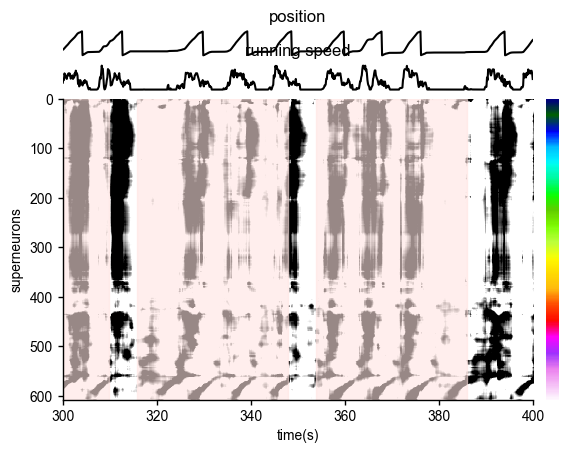

In [10]:
plot_rastermap_sort(raster_input, res, trange=(300,400))

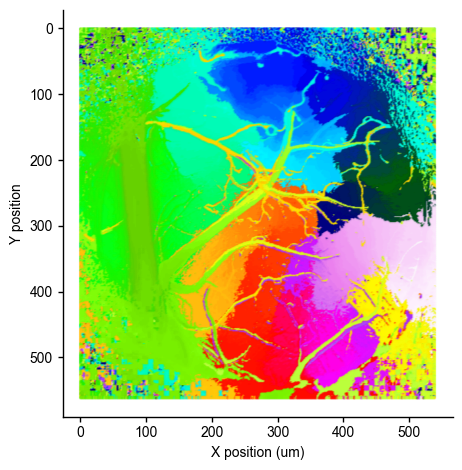

In [9]:
plot_raster_voxel(raster_input, res)